# fbb scheleton notebook for PUI2016 HW6

In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import seaborn
import statsmodels.api as sm
import statsmodels.formula.api as smf

#s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
#if os.getenv("PUIDATA") is None:
#    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


## An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
## So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

## Either obtain the data through the API or download the csv file, and move it to $PUIDATA

## However this datasets does not have the number of units. We can find that in the Pluto dataset.

## Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [51]:
#download, and move data to local, and read data in 

nrg = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
bsize = gp.read_file("Manhattan/MNMapPLUTO.shp")

In [24]:
nrg.head()

,Record Number,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [25]:
bsize.head()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,0.000000e+00,None,310 EAST 109 STREET,R7A,None,2,140102.0,343271.0,1.016800e+09,12000,...,0,1910,None,10029,R7A,None,None,None,6b,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,0.000000e+00,None,720 PARK AVENUE,R10/PI/LH-1A,R8B,2,5040000.0,30591900.0,1.013850e+09,203490,...,2006,1928,None,10021,R10,R8B,None,None,8c,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,0.000000e+00,None,3 WEST 83 STREET,R8B,R10A,2,437850.0,1267200.0,1.011970e+09,13839,...,0,1900,None,10024,R8B,R10A,None,None,5d,"POLYGON ((992273.6850000024 224863.4904000014,..."


In [26]:
nrg.columns

Index([u'Record Number', u'NYC Borough, Block, and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

In [27]:
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14ccfa890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14dab3e90>]], dtype=object)

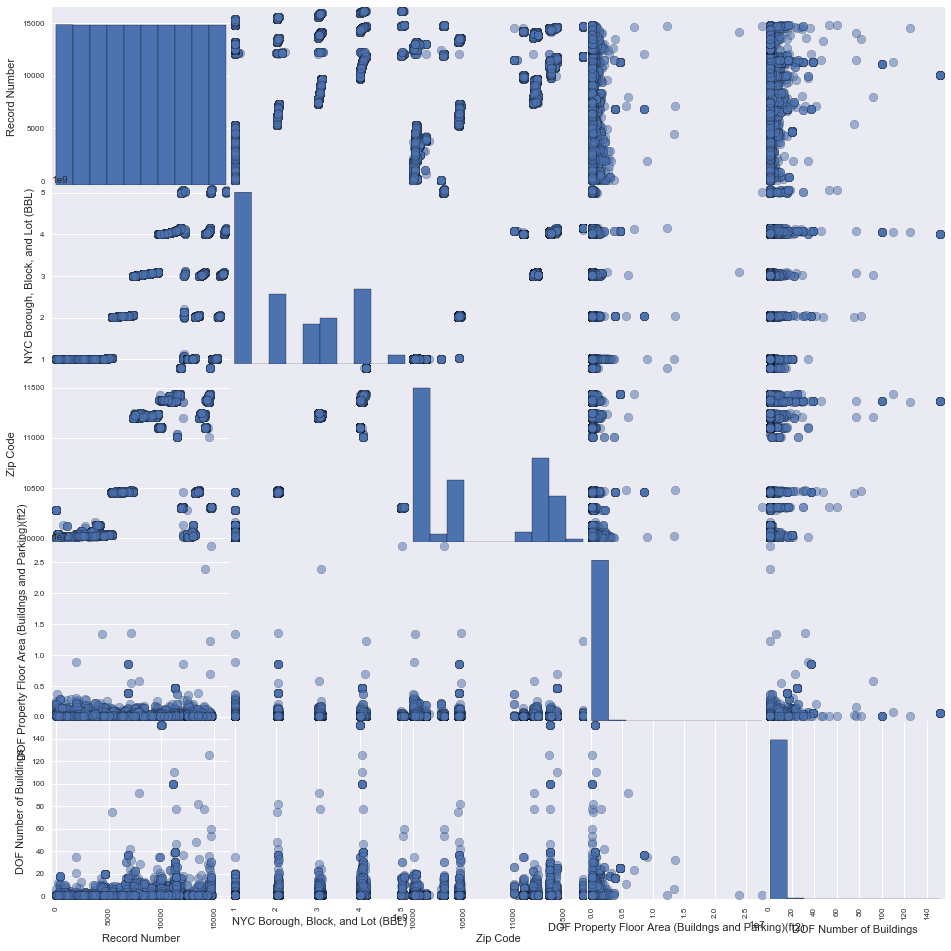

In [28]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16))

### Figure 1: scatter matrix of all numerical values in the Energy_and_Water_Data_Disclosure_for_Local_Law csv files.

In [52]:
# make sure you clean up your data and throw away columns you do not need!
nrg.drop(['Record Number',
       'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)',
       'Street Number', 'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'], axis = 1, inplace = True)

In [53]:
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Site EUI(kBtu/ft2)',
       u'Reported Property Floor Area (Building(s)) (ft²)'],
      dtype='object')

In [54]:
bsize.drop([u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
                 u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidFAR',
       u'RetailArea', u'SHAPE_Area', u'SHAPE_Leng',    u'SPDist1',
          u'SPDist2',    u'Sanborn',  u'SanitBoro',  u'SanitDist',
         u'SanitSub', u'SchoolDist',  u'SplitZone',  u'StrgeArea',
           u'TaxMap',  u'Tract2010',   u'UnitsRes', 
          u'Version',     u'XCoord',     u'YCoord', u'YearAlter1',
       u'YearAlter2',  u'YearBuilt',     u'ZMCode',    u'ZipCode',
        u'ZoneDist1',  u'ZoneDist2',  u'ZoneDist3',  u'ZoneDist4',
          u'ZoneMap',   u'geometry'], axis = 1, inplace = True)

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them.
Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.
This has to be done entry by entry: if you give it a series you get error "cannot convert the series to..."
However you can pass it a whole array by using it in conjunction with np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.

In [55]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
        


Now for every column I care about I can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that I want to use from my arrays of interest. 

I can replace the entries that failed to be converted to 'NaN'
(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx) 

In [56]:
#example
indx = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Site EUI(kBtu/ft2)'][~indx] = float('NaN')
nrg["Site EUI(kBtu/ft2)"] = nrg["Site EUI(kBtu/ft2)"].apply(lambda x: float(x))
#do it for however many columns you need

invalid entries changed to NaN 15513


/Users/chenhongting/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
indx2 = (np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)']))
print ("invalid entries changed to NaN %d"%sum(indx2))
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx2] = float('NaN')
nrg["Reported Property Floor Area (Building(s)) (ft²)"] = nrg["Reported Property Floor Area (Building(s)) (ft²)"].apply(lambda x: float(x))
#do it for however many columns you need

invalid entries changed to NaN 15430


/Users/chenhongting/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [58]:
indx1 = (np.vectorize(canconvert)(bsize['UnitsTotal']))
print ("invalid entries changed to NaN %d"%sum(indx1))
bsize['UnitsTotal'][~indx1] = float('NaN')
bsize["UnitsTotal"] = bsize["UnitsTotal"].apply(lambda x: float(x))
#do it for however many columns you need
#do it for however many columns you need

/Users/chenhongting/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


invalid entries changed to NaN 42697


# MERGE THE DATASET
TO DO IT WE NEED A COMMON COLUMN: the building id BBL However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!)

In [59]:
# prepare your BBL columns
nrg = nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)': 'BBL'})

In [60]:
#merge
bblnrgdata = pd.merge(nrg, bsize, on = 'BBL')

/Users/chenhongting/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


In [61]:
bblnrgdata.columns

Index([                                             u'BBL',
                                     u'Site EUI(kBtu/ft2)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
                                             u'UnitsTotal'],
      dtype='object')

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building. Remember: **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [62]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal
0,1.006700e+09,NaN,NaN,1.0
1,1.004370e+09,NaN,NaN,4.0
2,1.013110e+09,125.4,330000.0,56.0
3,1.009220e+09,NaN,NaN,148.0
4,1.007400e+09,NaN,68329.0,1.0


In [63]:
bblnrgdata['Total Energy Comsumpltion'] = bblnrgdata.apply(lambda x :x["Site EUI(kBtu/ft2)"] * x["Reported Property Floor Area (Building(s)) (ft²)"], axis=1)
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal,Total Energy Comsumpltion
0,1.006700e+09,NaN,NaN,1.0,NaN
1,1.004370e+09,NaN,NaN,4.0,NaN
2,1.013110e+09,125.4,330000.0,56.0,41382000.0
3,1.009220e+09,NaN,NaN,148.0,NaN
4,1.007400e+09,NaN,68329.0,1.0,NaN


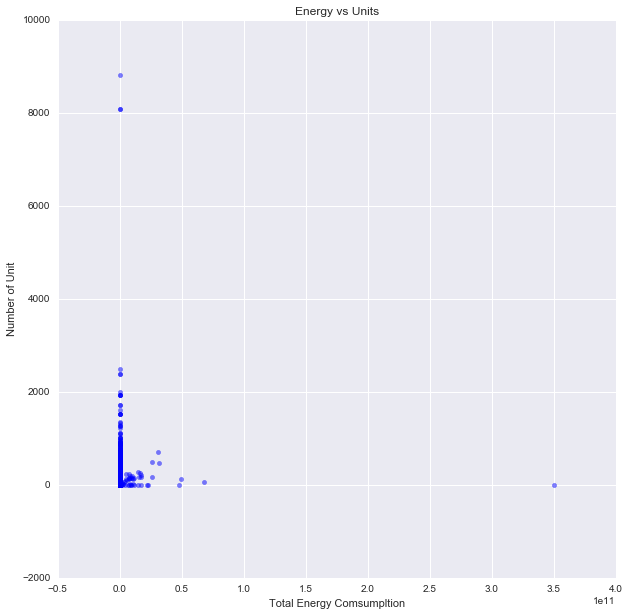

In [74]:
pl.figure(figsize = (10,10))
pl.scatter(bblnrgdata["Total Energy Comsumpltion"],bblnrgdata.UnitsTotal, color = 'blue', alpha = 0.5)
pl.xlabel("Total Energy Comsumpltion")
pl.ylabel("Number of Unit")
title = pl.title("Energy vs Units")

### Figure 2: Scatter plot : Energy vs Units.

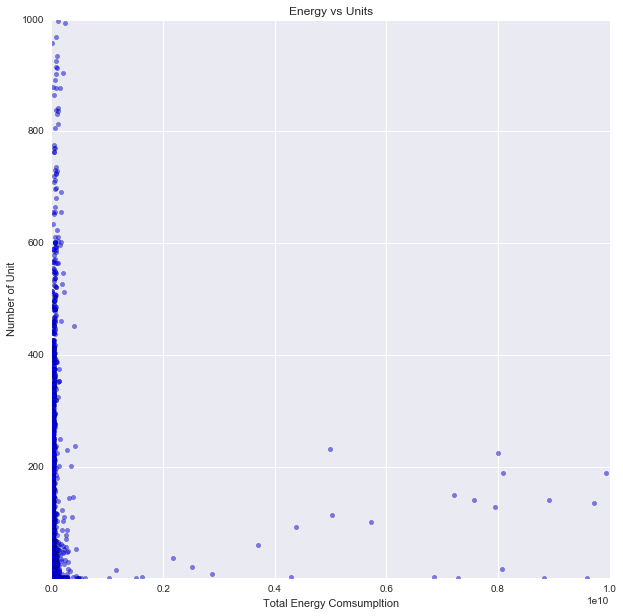

In [75]:
ax = bblnrgdata.plot.scatter(x = "Total Energy Comsumpltion", y = "UnitsTotal",color = 'blue', alpha = 0.5, figsize = (10,10))
ax.set_ylim(1,1000)
ax.set_xlim(1000,1e10)
ax.set_xlabel("Total Energy Comsumpltion")
ax.set_ylabel("Number of Unit")
title = pl.title("Energy vs Units")
pl.show()


### Figure 3: Zoomed in scatter plot : Energy vs Units.

when the points in a plot all look scrunched against the axis 

**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



In [78]:
bblnrgdata = bblnrgdata[~bblnrgdata["Total Energy Comsumpltion"].isnull()]
bblnrgdata_cut = bblnrgdata[(bblnrgdata["Total Energy Comsumpltion"]>1000)&(bblnrgdata['UnitsTotal']>10)]
bblnrgdata_cut.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal,Total Energy Comsumpltion
2,1.013110e+09,125.4,330000.0,56.0,41382000.0
16,1.008150e+09,117.0,364000.0,24.0,42588000.0
18,1.005050e+09,82.1,235370.0,24.0,19323877.0
19,1.021420e+09,137.7,64806.0,62.0,8923786.2
20,1.021750e+09,103.2,62839.0,85.0,6484984.8


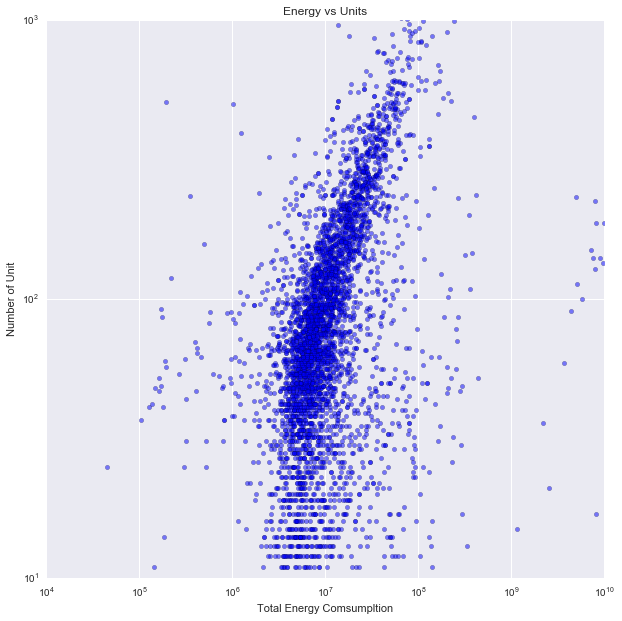

In [79]:
ax = bblnrgdata_cut.plot.scatter(x = "Total Energy Comsumpltion", y = "UnitsTotal",color = 'blue', alpha = 0.5, loglog = True,  figsize = (10,10))
ax.set_ylim(10,1000)
ax.set_xlim(10000,1e10)
ax.set_xlabel("Total Energy Comsumpltion")
ax.set_ylabel("Number of Unit")
title = pl.title("Energy vs Units")
pl.show()

### Figure 4: Log plot : Energy vs Units.

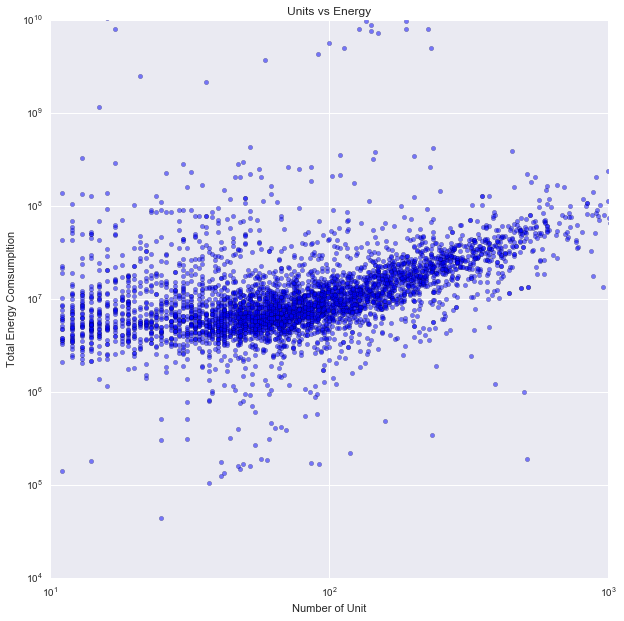

In [80]:
ax = bblnrgdata_cut.plot.scatter(y = "Total Energy Comsumpltion", x = "UnitsTotal",color = 'blue', alpha = 0.5, loglog = True,  figsize = (10,10))
ax.set_xlim(10,1000)
ax.set_ylim(10000,1e10)
ax.set_ylabel("Total Energy Comsumpltion")
ax.set_xlabel("Number of Unit")
title = pl.title("Units vs Energy")
pl.show()

### Figure 5: Log plot : Units vs Energy.

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


In [95]:
X1 = sm.add_constant(np.log10(bblnrgdata_cut['Total Energy Comsumpltion']))
linmodel1 = sm.OLS(np.log10(bblnrgdata_cut['UnitsTotal']), X1, missing='drop').fit() 
pridict1 = linmodel1.predict()
Y1 = np.log10(bblnrgdata_cut['UnitsTotal'])
sigma1 = Y1 / 2
chi1 = ((Y1-pridict1)**2 / sigma1**2).sum()

In [96]:
linmodel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     904.7
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          1.99e-180
Time:                        21:43:10   Log-Likelihood:                -1806.3
No. Observations:                4266   AIC:                             3617.
Df Residuals:                    4264   BIC:                             3629.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
const                        -0.5658      0.082     -6.886      0.000        -0.727    -0.405
Total Energy Comsumpltion     0.3505      0.012     30.079      0.000         0.328     0.373
==============================================================================
Omnibus:                      113.206   Durbin-Watson:                   1.344
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.763
Skew:                          -0.239   Prob(JB):                     1.69e-41
Kurtosis:                       3.910   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

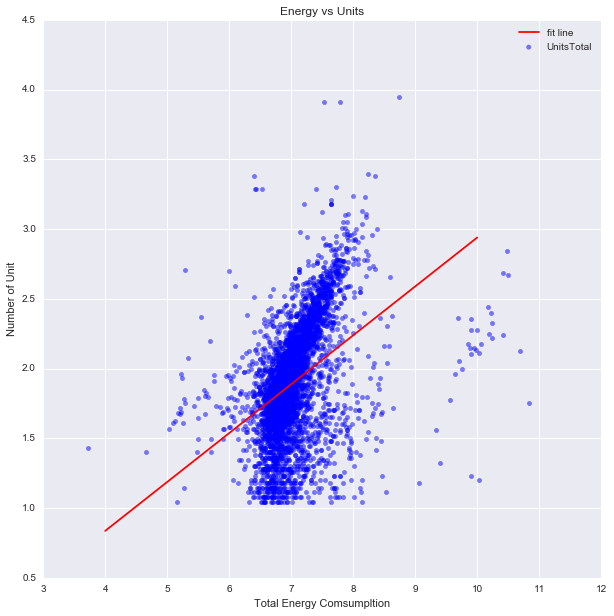

In [109]:
pl.figure(figsize = (10,10))
pl.scatter(log10(bblnrgdata_cut["Total Energy Comsumpltion"]), log10(bblnrgdata_cut["UnitsTotal"]),color = 'blue', alpha = 0.5)
xtest = np.linspace(4,10,800)
x_fit = sm.add_constant(xtest)
pl.plot(xtest, linmodel1.predict(x_fit), 'r-', label="fit line")
pl.xlabel("Total Energy Comsumpltion")
pl.ylabel("Number of Unit")
pl.legend()
title = pl.title("Energy vs Units")
pl.show()

### Figure 6: Log plot: Energy vs Units and its fit line.

In [98]:
X2 = sm.add_constant(np.log10(bblnrgdata_cut['UnitsTotal']))
linmodel2 = sm.OLS(np.log10(bblnrgdata_cut['Total Energy Comsumpltion']), X2, missing='drop').fit() 
pridict2 = linmodel2.predict()
Y2 = np.log10(bblnrgdata_cut['UnitsTotal'])
sigma1 = Y2 / 2
chi2 = ((Y2-pridict2)**2 / sigma1**2).sum()

In [111]:
linmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Total Energy Comsumpltion   R-squared:                       0.175
Model:                                   OLS   Adj. R-squared:                  0.175
Method:                        Least Squares   F-statistic:                     904.7
Date:                       Wed, 19 Oct 2016   Prob (F-statistic):          1.99e-180
Time:                               22:10:24   Log-Likelihood:                -2561.7
No. Observations:                       4266   AIC:                             5127.
Df Residuals:                           4264   BIC:                             5140.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0867      0.032    188.659      0.000         6.023     6.150
UnitsTotal     0.4994      0.017     30.079      0.000         0.467     0.532
==============================================================================
Omnibus:                     2245.418   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45084.375
Skew:                           2.059   Prob(JB):                         0.00
Kurtosis:                      18.384   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

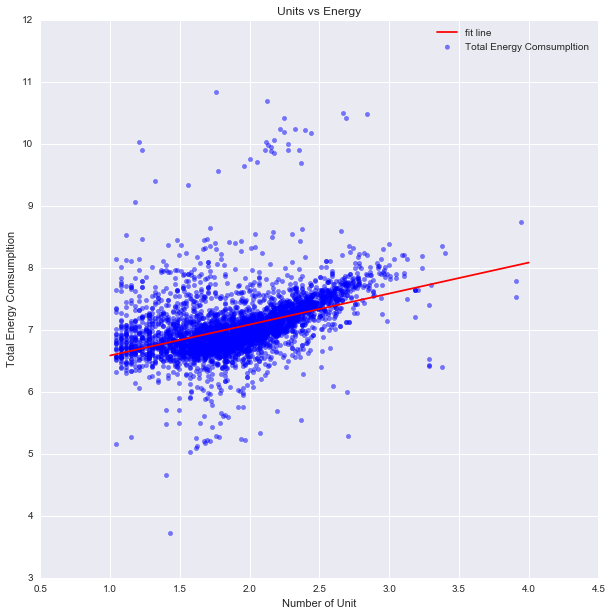

In [133]:
pl.figure(figsize = (10,10))
pl.scatter(log10(bblnrgdata_cut["UnitsTotal"]), log10(bblnrgdata_cut["Total Energy Comsumpltion"]),color = 'blue', alpha = 0.5)
xtest = np.linspace(1,4,800)
x_fit = sm.add_constant(xtest)
pl.plot(xtest, linmodel2.predict(x_fit), 'r-', label="fit line")
pl.ylabel("Total Energy Comsumpltion")
pl.xlabel("Number of Unit")
pl.legend()
title = pl.title("Units vs Energy")
pl.show()

### Figure 7 : Log plot: Units vs Energy and its fit line.

In [120]:
# chisquare for model 1
chi1

936.4058063264214

In [121]:
# chisquare for model 2
chi2

149879.2682438925

### Chisquare 2 > chisquare 1. So model2 is better where Total Energy Comsuption is and Total Units is INDEPENDENT

In [123]:
bblnrgdata_cut.head()
#nrg = nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)': 'BBL'})

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal,Total Energy Comsumpltion
2,1.013110e+09,125.4,330000.0,56.0,41382000.0
16,1.008150e+09,117.0,364000.0,24.0,42588000.0
18,1.005050e+09,82.1,235370.0,24.0,19323877.0
19,1.021420e+09,137.7,64806.0,62.0,8923786.2
20,1.021750e+09,103.2,62839.0,85.0,6484984.8


In [128]:
df = pd.DataFrame()
df['Unittol'] = np.log10(bblnrgdata_cut["UnitsTotal"])
df['Unittol2'] = df['Unittol']**2
df['Eng'] = np.log10(bblnrgdata_cut["Total Energy Comsumpltion"])

df.head()

,Unittol,Unittol2,Eng
2,1.748188,3.056161,7.616811
16,1.380211,1.904983,7.629287
18,1.380211,1.904983,7.286094
19,1.792392,3.212668,6.950549
20,1.929419,3.722657,6.811909


In [130]:
linmodel3 = smf.ols(formula = 'Eng ~ Unittol + Unittol2', data = df).fit()

In [131]:
linmodel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Eng   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     567.2
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          3.87e-219
Time:                        22:39:28   Log-Likelihood:                -2468.9
No. Observations:                4266   AIC:                             4944.
Df Residuals:                    4263   BIC:                             4963.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.4293      0.102     72.492      0.000         7.228     7.630
Unittol       -0.9278      0.105     -8.844      0.000        -1.134    -0.722
Unittol2       0.3626      0.026     13.771      0.000         0.311     0.414
==============================================================================
Omnibus:                     2280.521   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55223.028
Skew:                           2.042   Prob(JB):                         0.00
Kurtosis:                      20.146   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
linmodel3.params

Intercept    7.429299
Unittol     -0.927823
Unittol2     0.362637
dtype: float64

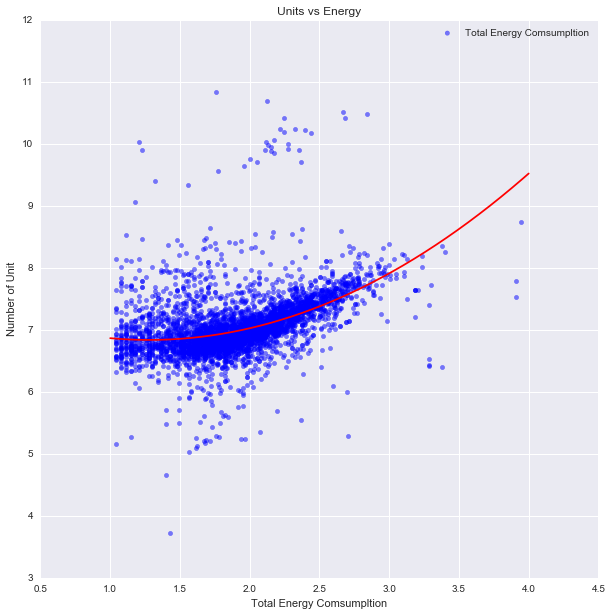

In [146]:
pl.figure(figsize = (10,10))
pl.scatter(log10(bblnrgdata_cut["UnitsTotal"]), log10(bblnrgdata_cut["Total Energy Comsumpltion"]),color = 'blue', alpha = 0.5)

XXtest = np.linspace(1,4,500)
YYtest = XXtest * linmodel3.params[1]  + (XXtest**2) * linmodel3.params[2] + linmodel3.params[0]
plt.plot(XXtest, YYtest, color = 'red')

pl.xlabel("Total Energy Comsumpltion")
pl.ylabel("Number of Unit")
pl.legend()
title = pl.title("Units vs Energy")
pl.show()


### Figure 8: Fit a 2nd degree polynomial to the Units vs Energy.

In [148]:
##Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test.
logLikelihood_Model1 = -2561.7
logLikelihood_Model2 = -2468.9
LR = -2 * (logLikelihood_Model1 - logLikelihood_Model2)
LR

185.59999999999945

    
4. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2+bx+c$ .

5. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2)
    
    where Model1 is the least complex (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels.
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferible to Model2. The LR is chi^2 distributed with number of degrees of freedom N_{DOF} = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



In [41]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)

In [ ]:
print ("LR : ", -2 * (-linemodel.llf - (-curvemodel.llf)))
print ("LR from statsmodels:", curvemodel.compare_lr_test(linemodel))

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

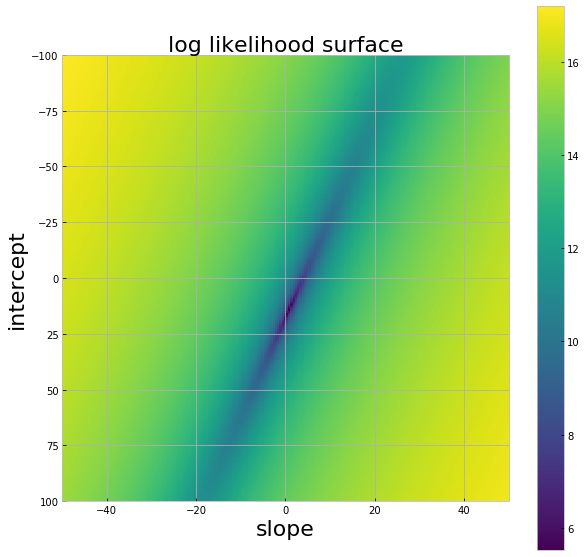

In [42]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5,0,'total energy consumption (kBtu)')

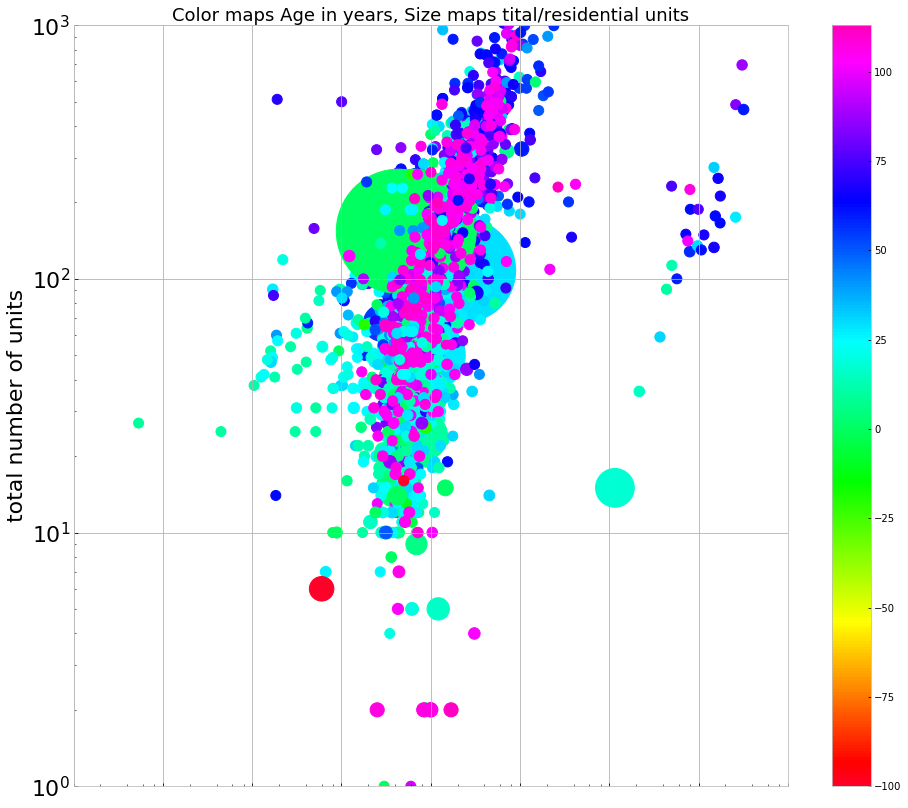

In [49]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)